In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,BatchNormalization, Flatten,MaxPooling2D, Concatenate,LeakyReLU,PReLU,Dropout,GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import cv2
import random
import PIL 
from skimage.io import imsave
import matplotlib.pyplot as plt


In [2]:
#Inicializacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
orig_imgs='C:/Users/komej/dataset2/images/'
mask_imgs='C:/Users/komej/dataset2/mask/'
labels_path='C:/Users/komej/dataset2/labels2.csv'

In [ ]:
#Wczytanie pliku csv z nazwami plików i etykietami do nich
df=pd.read_csv(labels_path)

In [ ]:
df.head()

,orginal_images,mask_images,object
0,1.jpg,mask_1.jpg,1
1,2.jpg,mask_2.jpg,1
2,3.jpg,mask_3.jpg,1
3,4.jpg,mask_4.jpg,1
4,5.jpg,mask_5.jpg,1


In [ ]:
df.dtypes

In [7]:
def build_model():
    input_img=Input(shape=(160,220,3),name='RGB_img')
    mask_input=Input(shape=(160,220,3),name='Mask_img')

    conv1=Conv2D(32,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(input_img)
    conv_m=Conv2D(32,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(mask_input)
    con=Concatenate()([conv1,conv_m])
    conv_a=Conv2D(64,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(con)
    h=MaxPooling2D((2,2))(conv_a)
    conv2=Conv2D(64,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(h)
    h2=MaxPooling2D((2,2))(conv2)
    conv3=Conv2D(64,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(h2)
    h3=MaxPooling2D((2,2))(conv3)
    conv4=Conv2D(64,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(h3)
    h4=MaxPooling2D((2,2))(conv4)
    conv5=Conv2D(128,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(h4)
    h5=MaxPooling2D((2,2))(conv5)
    conv6=Conv2D(128,kernel_size=(3,3),activation='relu',strides=1,padding='same',kernel_initializer='he_uniform')(h5)
    fl=Flatten()(conv6)
    d1=Dense(128,activation='relu')(fl)
    drp1=Dropout((0.1))(d1)
    d2=Dense(64,activation='relu')(drp1)
    drp2=Dropout((0.1))(d2)
    d3=Dense(32,activation=LeakyReLU())(drp2)
    out=Dense(1,activation='sigmoid')(d3)

    model=Model([input_img,mask_input],out)
    return model


In [8]:
model=build_model()

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_img (InputLayer)           [(None, 160, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 Mask_img (InputLayer)          [(None, 160, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 160, 220, 32  896         ['RGB_img[0][0]']                
                                )                                                           

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['mse','accuracy'],run_eagerly=False)

In [ ]:
tf.keras.utils.plot_model(model,to_file='C:/Users/komej/dataset2/model.png',show_shapes=True,show_dtype=True)

In [ ]:
#Funkcja oparta na generatorze, której zadaniem jest wczytanie do pamięci zadaną ilość danych(zdjęć) i etykiet opisujące je.
def batch_gen(batch_size,input_path,label_csv):
    while(1):
        images=os.listdir(input_path)
        img_batches=np.random.choice(images,size=batch_size)
        all=img_batches[:]
        df1=pd.read_csv(label_csv)
        del df1['mask_images']
        df1.set_index('orginal_images',inplace=True,drop=True)
        df1=df1.loc[all]
        y=df1['object'].values
        y=y.astype('float32')
        #print(y)
        org_images=[]
        mask_images=[]
        for img in img_batches:
            o=cv2.imread(input_path+img)
            o=cv2.resize(o,(220,160),interpolation=cv.INTER_AREA)
            m=cv2.imread(mask_imgs+'mask_'+img)
            m=cv2.resize(m,(220,160),interpolation=cv.INTER_AREA)
            org_images.append(o)
            mask_images.append(m)
        org_images=np.array(org_images)/255
        mask_images=np.array(mask_images)/255
        org_images=org_images.astype('float32')
        mask_images=mask_images.astype('float32')

        yield(org_images,mask_images,y)

In [ ]:
plt.imshow(o_img[0])

In [ ]:
#Pętla trenująca sieć
batch_size=32
epochs=400
accuracy_l,loss_l,epoch_l=[],[],[]
batchgen=batch_gen(batch_size,orig_imgs,labels_path)
for e in range(1,epochs+1):
    o_img,m_img,y=next(batchgen)
    loss=model.train_on_batch([o_img,m_img],y)
    accuracy_l.append(loss[2])
    loss_l.append(loss[0])
    epoch_l.append(e)

    print('Epoch:',e)
    print('loss:','Crossentropy_loss:',loss[0],'MSE:',loss[1],'Accuracy:',loss[2])

Epoch: 1
loss: Crossentropy_loss: 0.01169133372604847 MSE: 0.0005852088797837496 Accuracy: 1.0
Epoch: 2
loss: Crossentropy_loss: 0.00899967085570097 MSE: 0.00032596231903880835 Accuracy: 1.0
Epoch: 3
loss: Crossentropy_loss: 0.011036420240998268 MSE: 0.0004885303787887096 Accuracy: 1.0
Epoch: 4
loss: Crossentropy_loss: 0.009813741780817509 MSE: 0.0005738112377002835 Accuracy: 1.0
Epoch: 5
loss: Crossentropy_loss: 0.02430630475282669 MSE: 0.0018393747741356492 Accuracy: 1.0
Epoch: 6
loss: Crossentropy_loss: 0.024975938722491264 MSE: 0.003705768147483468 Accuracy: 1.0
Epoch: 7
loss: Crossentropy_loss: 0.007745184935629368 MSE: 0.0004733928362838924 Accuracy: 1.0
Epoch: 8
loss: Crossentropy_loss: 0.004603298380970955 MSE: 0.00014230779197532684 Accuracy: 1.0
Epoch: 9
loss: Crossentropy_loss: 0.005188005045056343 MSE: 0.00014393214951269329 Accuracy: 1.0
Epoch: 10
loss: Crossentropy_loss: 0.006478115916252136 MSE: 0.00018626506789587438 Accuracy: 1.0
Epoch: 11
loss: Crossentropy_loss: 0.00

KeyboardInterrupt: ignored

Text(0, 0.5, 'Loss')

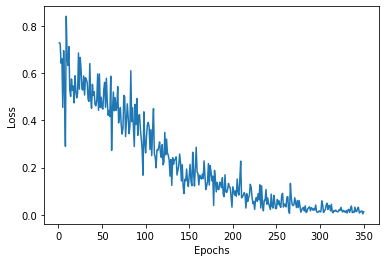

In [ ]:
plt.plot(epoch_l,loss_l)
plt.xlabel('Epochs')
plt.ylabel('Loss')

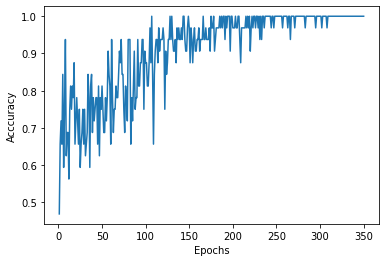

In [ ]:
plt.plot(epoch_l,accuracy_l)
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.show()

In [ ]:
model.save('C:/Users/komej/dataset2/drive_model13.h5')

In [ ]:
test_path='/content/gdrive/My Drive/test1.jpg'
mask_path='/content/gdrive/My Drive/test1_mask.jpg'
img=cv2.imread(test_path)
img=cv2.resize(img,(220,160),interpolation=cv2.INTER_CUBIC)
mask=cv2.imread(mask_path)
img=np.array(img,dtype=np.float32)/255
mask=np.array(mask,dtype=np.float32)/255
mask=np.expand_dims(mask,axis=0)
img=np.expand_dims(img,axis=0)
print(img.shape)
plt.imshow(img[0])

In [ ]:
score=model.predict(img)
print(score)

[[0.99989057]]
